# Visualizador das componentes do IMU

In [11]:
import asyncio
import struct
import time
import math
import numpy as np
from bleak import BleakClient
import matplotlib.pyplot as plt
import collections # Para usar deque para dados recentes
import nest_asyncio

Configurações BLE para o SnapKi:

In [12]:
IMU_SENSOR_ADDRESS = "84:71:27:AC:20:D2"
IMU_CHARACTERISTIC_UUID = "14181dce-eb95-46c5-8431-3b4fe0e0a12d"

Duração do trial:

In [13]:
TRIAL_TIME = 10
recording_start_time = None
is_recording = False
packet_count = 0 # Contador de pacotes recebidos
sample_index_counter = 0 # Contador para o índice total de amostras

Inicialização dos vetores com tamanho predefinido:

In [14]:
IMU_sampling_rate = 50 #Hz
BLE_notification_rate = 10 #Hz
samples_per_notification = IMU_sampling_rate // BLE_notification_rate
Total_samples = samples_per_notification * TRIAL_TIME

timestamps = [0.0] * Total_samples
accel_x_data = [0.0] * Total_samples
accel_y_data = [0.0] * Total_samples
accel_z_data = [0.0] * Total_samples
gyro_x_data = [0.0] * Total_samples
gyro_y_data = [0.0] * Total_samples
gyro_z_data = [0.0] * Total_samples
mag_x_data = [0.0] * Total_samples
mag_y_data = [0.0] * Total_samples
mag_z_data = [0.0] * Total_samples

Funções de extração de dados da IMU:

In [15]:
def extract_accel(data, i=0):
    """
    Extrai os valores do acelerómetro (ax, ay, az) de um pacote de dados da IMU.
    """
    offset = i * 44
    ax = struct.unpack("<f", data[offset:offset+4])[0]
    ay = struct.unpack("<f", data[offset+4:offset+8])[0]
    az = struct.unpack("<f", data[offset+8:offset+12])[0]
    return ax, ay, az

def extract_gyro(data, i=0):
    """
    Extrai os valores do giroscópio (gx, gy, gz) de um pacote de dados da IMU.
    """
    offset = i * 44
    gx = struct.unpack("<f", data[offset+12:offset+16])[0]
    gy = struct.unpack("<f", data[offset+16:offset+20])[0]
    gz = struct.unpack("<f", data[offset+20:offset+24])[0]
    return gx, gy, gz

def extract_mag(data, i=0):
    """
    Extrai os valores do magnetómetro (mx, my, mz) de um pacote de dados da IMU.
    """
    offset = i * 44
    mx = struct.unpack("<f", data[offset+24:offset+28])[0]
    my = struct.unpack("<f", data[offset+28:offset+32])[0]
    mz = struct.unpack("<f", data[offset+32:offset+36])[0]
    return mx, my, mz

Processamento dos dados IMU:

In [16]:
def process_imu_packet_for_recording(data_bytes):
    """
    Processa um pacote de dados da IMU, extrai todas as 5 amostras e as armazena.
    """
    global recording_start_time, is_recording, packet_count, sample_index_counter

    if len(data_bytes) < 220:
        print("Pacote BLE incompleto recebido.")
        return

    if not is_recording:
        return # Não faz nada se não estiver a gravar

    current_time = time.time()
    if recording_start_time is None: # Inicia o timer na primeira amostra
        recording_start_time = current_time
        print(f"Iniciando gravação por {TRIAL_TIME} segundos...")

    # Se a duração da gravação for atingida ou o número de amostras esperado for atingido, para.
    if current_time - recording_start_time >= TRIAL_TIME or \
       sample_index_counter >= Total_samples:
        if is_recording: # Só imprime uma vez ao parar
            print("Gravação concluída.")
        is_recording = False
        return

    packet_count += 1 # Incrementa o contador de pacotes

    # Itera sobre as 5 amostras dentro de cada pacote BLE
    for i in range(samples_per_notification):
        if sample_index_counter >= Total_samples:
            is_recording = False
            break # Não adicionar mais se já atingimos o limite

        # Extrai os dados para a amostra atual
        ax, ay, az = extract_accel(data_bytes, i)
        gx, gy, gz = extract_gyro(data_bytes, i)
        mx, my, mz = extract_mag(data_bytes, i)

        # Calcula o tempo relativo para esta amostra
        # Assumindo que as 5 amostras estão uniformemente espaçadas dentro do intervalo de 100ms da notificação
        time_offset_within_packet = i * (1.0 / IMU_sampling_rate)
        relative_timestamp = (current_time - recording_start_time) + time_offset_within_packet

        # Armazena os dados nos vetores pré-alocados
        timestamps[sample_index_counter] = relative_timestamp
        accel_x_data[sample_index_counter] = ax
        accel_y_data[sample_index_counter] = ay
        accel_z_data[sample_index_counter] = az
        gyro_x_data[sample_index_counter] = gx
        gyro_y_data[sample_index_counter] = gy
        gyro_z_data[sample_index_counter] = gz
        mag_x_data[sample_index_counter] = mx
        mag_y_data[sample_index_counter] = my
        mag_z_data[sample_index_counter] = mz

        sample_index_counter += 1 # Incrementa o contador de amostras total

Gráficos:

In [17]:
def plot_sensor_data():
    """
    Cria um subplot para cada sensor (acelerómetro, giroscópio, magnetómetro)
    e plota as componentes X, Y, Z para cada um.
    Ajusta para plotar apenas os dados realmente recolhidos.
    """
    # Remove os zeros restantes das listas pré-alocadas se não foram todas preenchidas
    actual_timestamps = timestamps[:sample_index_counter]
    if not actual_timestamps:
        print("Nenhuns dados recolhidos para plotar.")
        return

    # Corta os dados para o número real de amostras recolhidas
    actual_accel_x = accel_x_data[:sample_index_counter]
    actual_accel_y = accel_y_data[:sample_index_counter]
    actual_accel_z = accel_z_data[:sample_index_counter]
    actual_gyro_x = gyro_x_data[:sample_index_counter]
    actual_gyro_y = gyro_y_data[:sample_index_counter]
    actual_gyro_z = gyro_z_data[:sample_index_counter]
    actual_mag_x = mag_x_data[:sample_index_counter]
    actual_mag_y = mag_y_data[:sample_index_counter]
    actual_mag_z = mag_z_data[:sample_index_counter]

    fig, axs = plt.subplots(3, 1, figsize=(12, 10)) # 3 linhas, 1 coluna de subplots

    # Plot do Acelerómetro
    axs[0].plot(actual_timestamps, actual_accel_x, label='Accel X')
    axs[0].plot(actual_timestamps, actual_accel_y, label='Accel Y')
    axs[0].plot(actual_timestamps, actual_accel_z, label='Accel Z')
    axs[0].set_title('Acelerómetro')
    axs[0].set_ylabel('Aceleração (g)')
    axs[0].legend()
    axs[0].grid(True)

    # Plot do Giroscópio
    axs[1].plot(actual_timestamps, actual_gyro_x, label='Gyro X')
    axs[1].plot(actual_timestamps, actual_gyro_y, label='Gyro Y')
    axs[1].plot(actual_timestamps, actual_gyro_z, label='Gyro Z')
    axs[1].set_title('Giroscópio')
    axs[1].set_ylabel('Velocidade Angular (deg/s)')
    axs[1].legend()
    axs[1].grid(True)

    # Plot do Magnetómetro
    axs[2].plot(actual_timestamps, actual_mag_x, label='Mag X')
    axs[2].plot(actual_timestamps, actual_mag_y, label='Mag Y')
    axs[2].plot(actual_timestamps, actual_mag_z, label='Mag Z')
    axs[2].set_title('Magnetómetro')
    axs[2].set_xlabel('Tempo (s)')
    axs[2].set_ylabel('Força Magnética (uT)')
    axs[2].legend()
    axs[2].grid(True)

    plt.tight_layout() # Ajusta o layout para evitar sobreposição
    plt.show() # Mostra a janela do plot

Conectar ao SnapKi e gravar os dados:


 SnapKi conectado.
A gravação de dados começará assim que uma notificação for recebida e terminará após 10 segundos.
Aguardando o início da gravação...
Iniciando gravação por 10 segundos...
Gravação concluída.
Total de pacotes BLE processados: 10
Gravação de dados concluída. A parar notificações BLE...
Notificações BLE paradas.


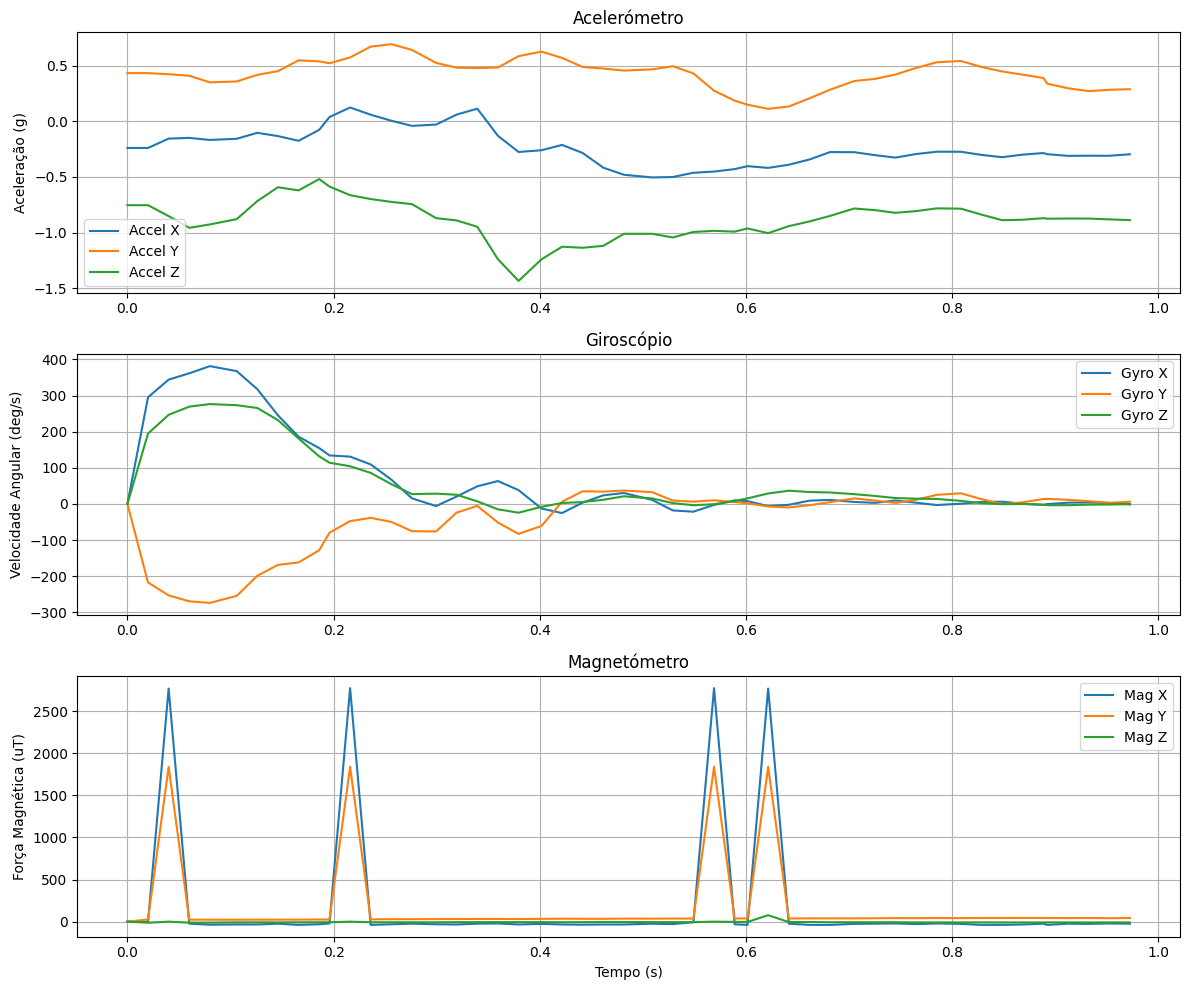

Sessão terminada.


In [18]:
async def imu_notification_handler(sender, data_bytes):
    process_imu_packet_for_recording(data_bytes)

# Main function
async def connect_and_record_imu():
    global is_recording, recording_start_time, packet_count, sample_index_counter, \
        timestamps, accel_x_data, accel_y_data, accel_z_data, gyro_x_data, gyro_y_data, \
        gyro_z_data, mag_x_data, mag_y_data, mag_z_data

    # Reinicia contadores e flags para uma nova gravação
    is_recording = False
    recording_start_time = None
    packet_count = 0
    sample_index_counter = 0

    try:
        async with BleakClient(IMU_SENSOR_ADDRESS) as client:
            if not client.is_connected:
                print(f"Não foi possível conectar ao SnapKi em {IMU_SENSOR_ADDRESS}")
                return

            print("\n SnapKi conectado.")
            print(f"A gravação de dados começará assim que uma notificação for recebida e terminará após {TRIAL_TIME} segundos.")

            await client.start_notify(IMU_CHARACTERISTIC_UUID, imu_notification_handler)

            is_recording = True # Ativa a gravação
            print("Aguardando o início da gravação...")

            # Mantém o cliente BLE a correr enquanto a gravação está ativa
            # Aguarda até que a gravação termine
            while is_recording:
                await asyncio.sleep(0.01) # Pequena pausa para permitir que o Bleak processe as notificações

            print(f"Total de pacotes BLE processados: {packet_count}")
            print("Gravação de dados concluída. A parar notificações BLE...")
            await client.stop_notify(IMU_CHARACTERISTIC_UUID)
            print("Notificações BLE paradas.")

            # Chama a função de plotagem após a gravação
            plot_sensor_data()

    except Exception as e:
        print(f"Erro na conexão BLE ou durante a gravação: {e}")
    finally:
        print("Sessão terminada.")

nest_asyncio.apply()

if __name__ == "__main__":
    # Tenta obter o loop de eventos existente
    try:
        loop = asyncio.get_running_loop()
    except RuntimeError:
        # Se não houver um a correr, cria um novo
        loop = asyncio.new_event_loop()
        asyncio.set_event_loop(loop)

    # Executa a corrotina no loop de eventos
    loop.run_until_complete(connect_and_record_imu())